In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import constants as const
from astropy.time import Time
from astropy.time import TimeDelta
from astropy.coordinates import SkyCoord
from astropy import units as u
import csv
import os
import zipfile
import io
from scipy.interpolate import CubicSpline as cs

plt.rcParams["xtick.major.size"] = 9
plt.rcParams["xtick.major.width"] = 1.5
plt.rcParams["ytick.major.size"] = 9
plt.rcParams["ytick.major.width"] = 1.5
plt.rcParams["font.size"] = 14

pi = np.pi
AU = const.au.value

LAT = np.radians(-30.-(14./60.)-(40.68/3600.))                # from LSST's website
LONG = np.radians(-70.-(44./60.)-(57.90/3600.))

'''
Data for 'Oumuamua was likely taken from Meech et. al. (2017) or Mamajek (2017).  
Data for Borisov was likely taken from de Leon et. al. (2019). 
'''

"\nData for 'Oumuamua was likely taken from Meech et. al. (2017) or Mamajek (2017).  \nData for Borisov was likely taken from de Leon et. al. (2019). \n"

# Get orbit data

In [2]:
MAIN_PATH = 'C://Users/djhoo/Documents/ISO/iso_data'
os.chdir(MAIN_PATH)

NSAMPLES = 10*100000
NTIMES = 100

SING_KEYS = ['id', 'a', 'e', 'inc', 'Omega', 'omega', 'f', 'b']
MULTI_KEYS = ['time', 'year', 'month', 'day', 'sid_time', 'ra', 'dec', \
             'az', 'alt', 'ra_sun', 'dec_sun', 'az_sun', 'alt_sun', \
             'x', 'y', 'z', 'vx', 'vy', 'vz', 'mag', 'dist']

In [3]:
def get_key(keyname):
    if keyname in SING_KEYS:
        key = np.array([])
    else:
        key = np.array([[]]).reshape(0, NTIMES)
        
    for zf in os.listdir():
        key = np.concatenate((key, get_key_from_zip(keyname, zf)))
    return key

def get_key_from_zip(keyname, zf):
    in_sing_keys = keyname in SING_KEYS
    
    if in_sing_keys:
        ind = SING_KEYS.index(keyname)
    else:
        ind = MULTI_KEYS.index(keyname)
            
    with zipfile.ZipFile(zf, 'r') as z:
        if in_sing_keys:
            key = np.zeros(len(z.namelist()[1:]))
        else:
            key = np.zeros((len(z.namelist()[1:]), NTIMES))
        
        for i, tf in enumerate(z.namelist()[1:]):
            with io.TextIOWrapper(z.open(tf, 'r')) as f:
                reader = csv.reader(f)
                rows = list(reader)
                if in_sing_keys:
                    key[i] = rows[1][ind]
                else:
                    key[i] = np.array(rows[4:])[:, ind]
    
    return np.array(key)

In [4]:
orbits = {}
for key in np.concatenate((SING_KEYS, MULTI_KEYS)):
    print(key)
    orbits[key] = get_key(key)

id
a
e
inc
Omega
omega
f
b
time
year
month
day
sid_time
ra
dec
az
alt
ra_sun
dec_sun
az_sun
alt_sun
x
y
z
vx
vy
vz
mag
dist


In [5]:
NDETECT = len(orbits['a'])  
print('%d ISOs with minimum apparent magnitude lower than 24' %NDETECT)
print('%.3f %% rate' %(NDETECT/NSAMPLES*100))

69561 ISOs with minimum apparent magnitude lower than 24
6.956 % rate


In [6]:
orbits['datetime'] = np.dstack((orbits['year'], orbits['month'], \
                                    orbits['day']))
orbits['pos_eq'] = np.dstack((orbits['ra'], orbits['dec']))
orbits['pos_horiz'] = np.dstack((orbits['az'], orbits['alt']))
orbits['solar_pos_eq'] = np.dstack((orbits['ra_sun'], orbits['dec_sun']))
orbits['solar_pos_horiz'] = np.dstack((orbits['az_sun'], orbits['alt_sun']))
orbits['rad'] = np.dstack((orbits['x'], orbits['y'], orbits['z']))
orbits['vel'] = np.dstack((orbits['vx'], orbits['vy'], orbits['vz']))

In [7]:
os.chdir('C://Users/djhoo/Documents/ISO/')

# Find distributions

In [8]:
min_dist = np.zeros(NDETECT)
min_dist_time = np.zeros_like(min_dist)
for i in range(NDETECT):
    if i % 1000 == 0:
        print(i)
    spl = cs(orbits['time'][i], orbits['dist'][i])
    new_times = np.linspace(np.min(orbits['time'][i]), \
                           np.max(orbits['time'][i]), 1000000)
    min_dist[i] = np.min(spl(new_times))
    min_dist_time[i] = new_times[spl(new_times)==min_dist[i]][0]

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000


In [9]:
waittime = np.zeros(NDETECT)
for i in range(NDETECT):
    det_ind = np.where(orbits['mag'][i] <= 24.)[0][0]
    waittime[i] = np.abs(orbits['time'][i][det_ind] - \
                      min_dist_time[i])
waittime = waittime/(60*60*24)

dv = (min_dist*AU/1000.)/(waittime*24*60*60)
low_dv = dv <= 20.

<ipython-input-9-f781fd94f734>:8: RuntimeWarning: divide by zero encountered in true_divide
  dv = (min_dist*AU/1000.)/(waittime*24*60*60)


In [10]:
detectable = (orbits['mag'] <= 24.)*(orbits['pos_horiz'][:, :, 1] > np.radians(30.))*(orbits['solar_pos_horiz'][:, :, 1] < np.radians(-18.))
detectable = np.any(detectable==True, axis=1)
nobs = len(detectable[detectable==True])
        
print('Detections: %d' %nobs)
print('Detection rate: %.3f %%' %(nobs/NSAMPLES*100))

Detections: 31066
Detection rate: 3.107 %


In [11]:
n0 = 0.2
VOL = (4./3.)*pi*5.**3

print('LSST detection rate: %.3f objects per year' %(n0*VOL*nobs/(2.1*NSAMPLES)))

LSST detection rate: 1.549 objects per year


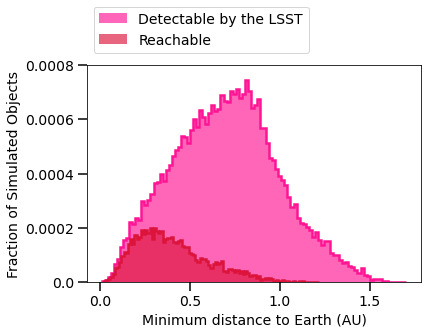

In [12]:
from scipy import stats

plt.hist(min_dist[detectable], bins=100, color='deeppink', alpha=0.65, \
        label='Detectable by the LSST')
plt.hist(min_dist[detectable], bins=100, edgecolor='deeppink', fill=None, \
        lw=2.5, histtype='step')
plt.hist(min_dist[(detectable)*(low_dv)], bins=100, color='crimson', alpha=0.65, \
        label='Reachable')
plt.hist(min_dist[(detectable)*(low_dv)], bins=100, edgecolor='crimson', fill=None, \
        lw=2.5, histtype='step')

plt.xlabel('Minimum distance to Earth (AU)')
plt.ylabel('Fraction of Simulated Objects')
plt.yticks([0, 200, 400, 600, 800], \
           np.array([0, 200, 400, 600, 800])/NSAMPLES)

plt.legend(bbox_to_anchor=(0., 1.3), loc='upper left')

plt.savefig('figures/min_dist_hist.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

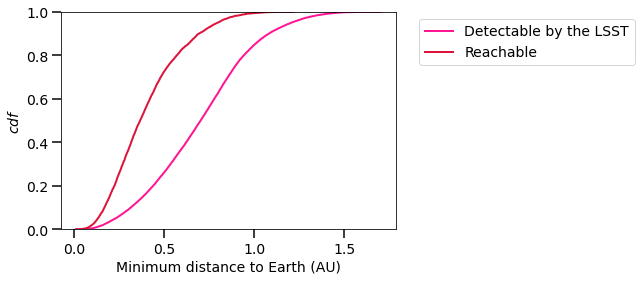

In [13]:
plt.plot(np.sort(np.squeeze(min_dist[detectable])), np.linspace(0, 1, len(min_dist[detectable])), \
         c='deeppink', lw=2, label='Detectable by the LSST')
plt.plot(np.sort(np.squeeze(min_dist[(detectable)*(low_dv)])), np.linspace(0, 1, len(min_dist[(detectable)*(low_dv)])), \
         c='crimson', lw=2, label='Reachable')

plt.xlabel('Minimum distance to Earth (AU)')
plt.ylabel(r'$cdf$')
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.savefig('figures/min_dist_cdf.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

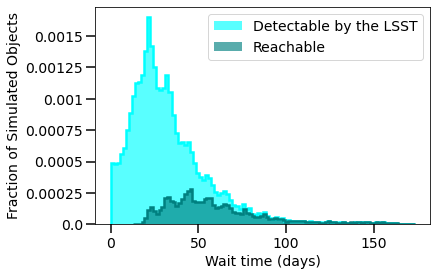

In [14]:
plt.hist(waittime[detectable], bins=100, color='aqua', alpha=0.65, \
        label='Detectable by the LSST')
plt.hist(waittime[detectable], bins=100, edgecolor='aqua', fill=None, \
        lw=2.5, histtype='step')
plt.hist(waittime[(detectable)*(low_dv)], bins=100, color='teal', alpha=0.65, \
        label='Reachable')
plt.hist(waittime[(detectable)*(low_dv)], bins=100, edgecolor='teal', fill=None, \
        lw=2.5, histtype='step')

plt.xlabel('Wait time (days)')
plt.ylabel('Fraction of Simulated Objects')
plt.yticks([0, 250, 500, 750, 1000, 1250, 1500], \
          np.array([0, 250, 500, 750, 1000, 1250, 1500])/NSAMPLES)

plt.legend(loc='upper right')
plt.savefig('figures/waittime_hist.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show() 

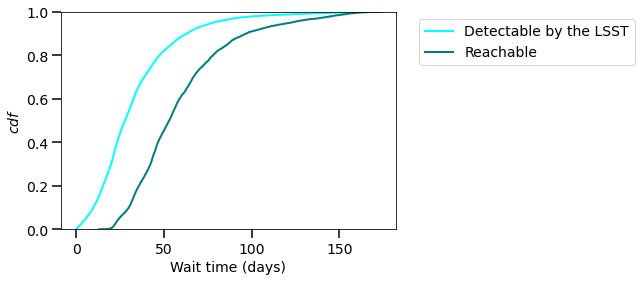

In [15]:
plt.plot(np.sort(np.squeeze(waittime[detectable])), np.linspace(0, 1, len(waittime[detectable])), \
         c='aqua', lw=2, label='Detectable by the LSST')
plt.plot(np.sort(np.squeeze(waittime[(detectable)*(low_dv)])), np.linspace(0, 1, len(waittime[(detectable)*(low_dv)])), \
         c='teal', lw=2, label='Reachable')

plt.xlabel('Wait time (days)')
plt.ylabel(r'$cdf$')
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.savefig('figures/waittime_cdf.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

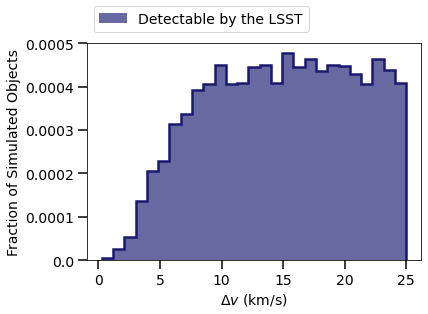

In [16]:
plt.hist(dv[(detectable)*(dv<=25.)], bins='auto', color='midnightblue', alpha=0.65, \
        label='Detectable by the LSST')
plt.hist(dv[(detectable)*(dv<=25.)], bins='auto', edgecolor='midnightblue', fill=None, \
        lw=2.5, histtype='step')

plt.xlabel(r'$\Delta v$ (km/s)')
plt.ylabel('Fraction of Simulated Objects')
plt.yticks([0, 100, 200, 300, 400, 500], \
           np.array([0, 100, 200, 300, 400, 500])/NSAMPLES)

plt.legend(bbox_to_anchor=(0., 1.2), loc='upper left')
plt.savefig('figures/deltav_hist.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

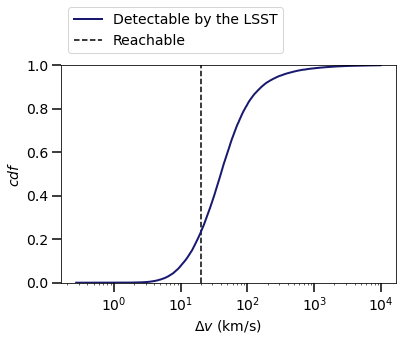

In [17]:
plt.plot(np.sort(np.squeeze(dv[(dv<=10000.)*detectable])), np.linspace(0, 1, len(dv[(dv<=10000.)*detectable])), \
         c='midnightblue', lw=2, label='Detectable by the LSST')

plt.vlines(20, 0, 100000, label="Reachable", linestyles='dashed', \
          colors='black')

plt.xlabel(r'$\Delta v$ (km/s)')
plt.xscale('log')

plt.ylabel(r'$cdf$')
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(0., 1.3), loc='upper left')

plt.savefig('figures/deltav_cdf.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

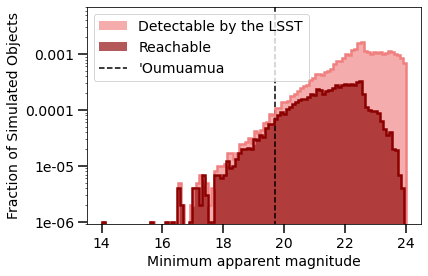

In [18]:
min_mag = np.min(orbits['mag'], axis=1)

plt.vlines(19.7, 0, 100000, label="'Oumuamua", linestyles='dashed', \
          colors='black')

plt.hist(min_mag[detectable], bins=100, color='lightcoral', alpha=0.65, \
        label='Detectable by the LSST')
plt.hist(min_mag[detectable], bins=100, edgecolor='lightcoral', fill=None, \
       histtype='step', lw=2.5)
plt.hist(min_mag[(low_dv)*(detectable)], bins=100, color='darkred', \
       alpha=0.65, label=r'Reachable')
plt.hist(min_mag[(low_dv)*(detectable)], bins=100, edgecolor='darkred', \
       fill=None, histtype='step', lw=2.5)

plt.xlabel('Minimum apparent magnitude')
plt.ylabel('Fraction of Simulated Objects')
plt.yscale('log')
plt.ylim(9*10**-1, 7*10**3)
plt.yticks([10**0, 10**1, 10**2, 10**3], \
           np.array([1, 10, 100, 1000])/NSAMPLES)

plt.legend(loc='upper left')
plt.savefig('figures/min_mag_hist.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

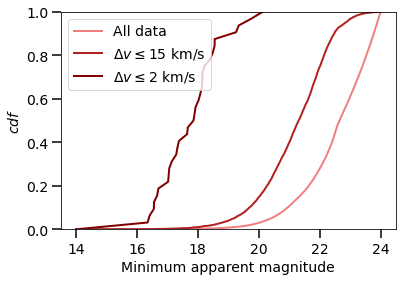

In [19]:
plt.plot(np.sort(np.squeeze(min_mag)), np.linspace(0, 1, len(min_mag)), c='lightcoral', \
         lw=2, label='All data')
plt.plot(np.sort(np.squeeze(min_mag[dv<=15])), np.linspace(0, 1, len(min_mag[dv<=15])), c='firebrick', \
         lw=2, label=r'$\Delta v\leq 15$ km/s')
plt.plot(np.sort(np.squeeze(min_mag[dv<=2])), np.linspace(0, 1, len(min_mag[dv<=2])), c='maroon', \
         lw=2, label=r'$\Delta v\leq 2$ km/s')

plt.xlabel('Minimum apparent magnitude')
plt.ylabel(r'$cdf$')
plt.ylim(0, 1)
plt.legend(loc='upper left')

plt.savefig('figures/min_mag_cdf.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

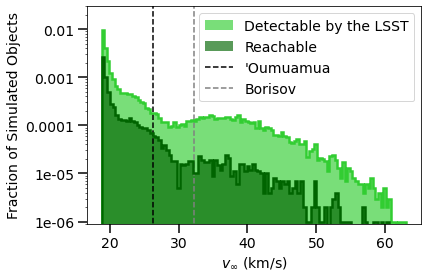

In [20]:
v_init = np.linalg.norm(orbits['vel'][:, 0], axis=1)*AU/1000.

plt.vlines(26.33, 0, 50000, label="'Oumuamua", linestyles='dashed', \
          colors='black')
plt.vlines(32.2, 0, 50000, label="Borisov", linestyles='dashed', \
          colors='grey')

plt.hist(v_init[detectable], bins='auto', color='limegreen', alpha=0.65, \
       label='Detectable by the LSST')
plt.hist(v_init[detectable], bins='auto', edgecolor='limegreen', fill=None, \
       histtype='step', lw=2.5)
plt.hist(v_init[(low_dv)*(detectable)], bins='auto', color='darkgreen', \
       alpha=0.65, label='Reachable')
plt.hist(v_init[(low_dv)*(detectable)], bins='auto', edgecolor='darkgreen', \
       fill=None, histtype='step', lw=2.5)

plt.xlabel(r'$v_{\infty}$ (km/s)')
plt.ylabel('Fraction of Simulated Objects')
plt.yscale('log')
plt.ylim(9*10**-1, 3*10**4)
plt.yticks([10**0, 10**1, 10**2, 10**3, 10**4], \
           np.array([1, 10, 100, 1000, 10000])/NSAMPLES)

plt.legend(loc='upper right')
plt.savefig('figures/v_init_hist.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

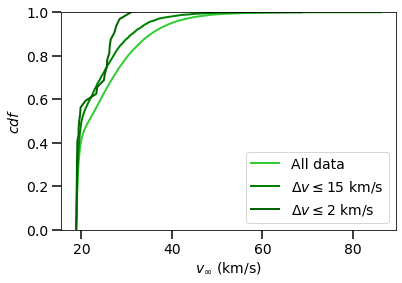

In [21]:
plt.plot(np.sort(np.squeeze(v_init)), np.linspace(0, 1, len(v_init)), c='limegreen', \
         lw=2, label='All data')
plt.plot(np.sort(np.squeeze(v_init[dv<=15])), np.linspace(0, 1, len(v_init[dv<=15])), c='green', \
         lw=2, label=r'$\Delta v\leq 15$ km/s')
plt.plot(np.sort(np.squeeze(v_init[dv<=2])), np.linspace(0, 1, len(v_init[dv<=2])), c='darkgreen', \
         lw=2, label=r'$\Delta v\leq 2$ km/s')

plt.xlabel(r'$v_{\infty}$ (km/s)')
plt.ylabel(r'$cdf$')
plt.ylim(0, 1)
plt.legend(loc='lower right')

plt.savefig('figures/v_init_cdf.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

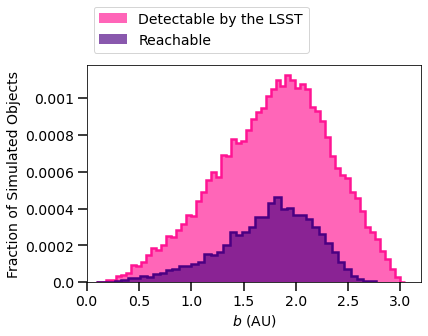

In [22]:
plt.hist(orbits['b'][detectable], bins='auto', color='deeppink', alpha=0.65, \
       label='Detectable by the LSST')
plt.hist(orbits['b'][detectable], bins='auto', edgecolor='deeppink', fill=None, \
       histtype='step', lw=2.5)
plt.hist(orbits['b'][(low_dv)*(detectable)], bins='auto', color='indigo', \
       alpha=0.65, label='Reachable')
plt.hist(orbits['b'][(low_dv)*(detectable)], bins='auto', edgecolor='indigo', \
       fill=None, histtype='step', lw=2.5)

plt.xlabel(r'$b$ (AU)')
plt.xlim(0, 3.2)
plt.ylabel('Fraction of Simulated Objects')
plt.yticks([0, 200, 400, 600, 800, 1000], np.array([0, 200, 400, 600, 800, 1000])/NSAMPLES)

plt.legend(bbox_to_anchor=(0., 1.3), loc='upper left')
plt.savefig('figures/b_hist.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

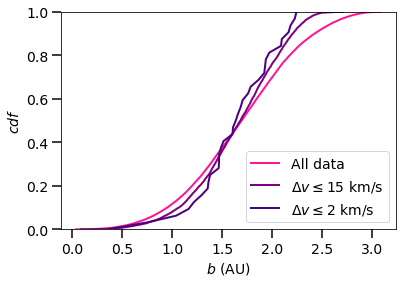

In [23]:
plt.plot(np.sort(np.squeeze(orbits['b'])), np.linspace(0, 1, len(orbits['b'])), c='deeppink', \
         lw=2, label='All data')
plt.plot(np.sort(np.squeeze(orbits['b'][dv<=15])), np.linspace(0, 1, len(orbits['b'][dv<=15])), c='purple', \
         lw=2, label=r'$\Delta v\leq 15$ km/s')
plt.plot(np.sort(np.squeeze(orbits['b'][dv<=2])), np.linspace(0, 1, len(orbits['b'][dv<=2])), c='indigo', \
         lw=2, label=r'$\Delta v\leq 2$ km/s')

plt.xlabel(r'$b$ (AU)')
plt.ylabel(r'$cdf$')
plt.ylim(0, 1)
plt.legend(loc='lower right')

plt.savefig('figures/b_cdf.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

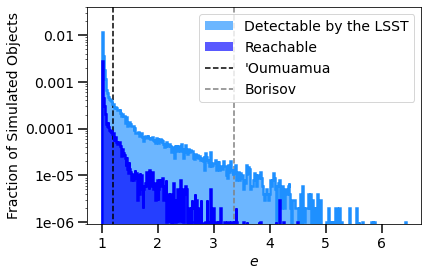

In [24]:
plt.vlines(1.201, 0, 500000, label="'Oumuamua", linestyles='dashed', \
          colors='black')
plt.vlines(3.357, 0, 500000, label="Borisov", linestyles='dashed', \
          colors='grey')

plt.hist(orbits['e'][(orbits['e']<8)*(detectable)], bins='auto', color='dodgerblue', alpha=0.65, \
       label='Detectable by the LSST')
plt.hist(orbits['e'][(orbits['e']<8)*(detectable)], bins='auto', edgecolor='dodgerblue', fill=None, \
       histtype='step', lw=2.5)
plt.hist(orbits['e'][(low_dv)*(detectable)], bins='auto', color='blue', \
       alpha=0.65, label='Reachable')
plt.hist(orbits['e'][(low_dv)*(detectable)], bins='auto', edgecolor='blue', \
       fill=None, histtype='step', lw=2.5)

plt.xlabel(r'$e$')

plt.ylabel('Fraction of Simulated Objects')
plt.yscale('log')
plt.ylim(9*10**-1, 4*10**4)
plt.yticks([10**0, 10**1, 10**2, 10**3, 10**4], \
           np.array([1, 10, 100, 1000, 10000])/NSAMPLES)

plt.legend(loc='upper right')
plt.savefig('figures/e_hist.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

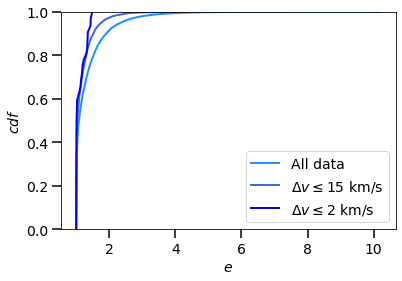

In [25]:
plt.plot(np.sort(np.squeeze(orbits['e'])), np.linspace(0, 1, len(orbits['e'])), c='dodgerblue', \
         lw=2, label='All data')
plt.plot(np.sort(np.squeeze(orbits['e'][dv<=15])), np.linspace(0, 1, len(orbits['e'][dv<=15])), c='royalblue', \
         lw=2, label=r'$\Delta v\leq 15$ km/s')
plt.plot(np.sort(np.squeeze(orbits['e'][dv<=2])), np.linspace(0, 1, len(orbits['e'][dv<=2])), c='blue', \
         lw=2, label=r'$\Delta v\leq 2$ km/s')

plt.xlabel(r'$e$')
plt.ylabel(r'$cdf$')
plt.ylim(0, 1)
plt.legend(loc='lower right')

plt.savefig('figures/e_cdf.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

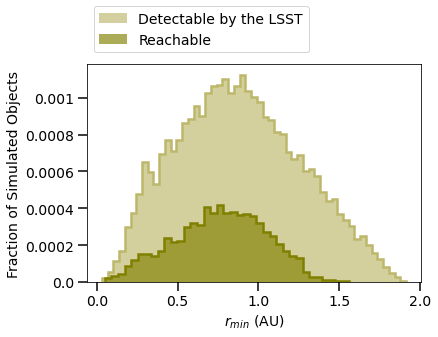

In [26]:
rmin = np.min(np.linalg.norm(orbits['rad'], axis=2), axis=1)

plt.hist(rmin[detectable], bins='auto', color='darkkhaki', alpha=0.65, label='Detectable by the LSST')
plt.hist(rmin[detectable], bins='auto', edgecolor='darkkhaki', lw=2.5, histtype='step')
plt.hist(rmin[(low_dv)*(detectable)], bins='auto', color='olive', alpha=0.65, label='Reachable')
plt.hist(rmin[(low_dv)*(detectable)], bins='auto', edgecolor='olive', lw=2.5, histtype='step')

plt.xlabel(r'$r_{min}$ (AU)')
plt.ylabel('Fraction of Simulated Objects')
plt.yticks([0, 200, 400, 600, 800, 1000], np.array([0, 200, 400, 600, 800, 1000])/NSAMPLES)

plt.legend(bbox_to_anchor=(0., 1.3), loc='upper left')
plt.savefig('figures/rmin_hist.pdf', bbox_inches='tight', \
                    dpi=250)

plt.show()

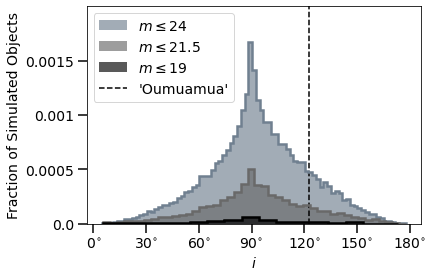

In [27]:
plt.hist(orbits['inc'][detectable], bins='auto', color='slategray', alpha=0.65, label=r'$m\leq24$')
plt.hist(orbits['inc'][detectable], bins='auto', edgecolor='slategray', lw=2.5, histtype='step')
plt.hist(orbits['inc'][(min_mag<=21.5)*(detectable)], bins='auto', color='dimgray', alpha=0.65, label=r'$m\leq 21.5$')
plt.hist(orbits['inc'][(min_mag<=21.5)*(detectable)], bins='auto', edgecolor='dimgray', lw=2.5, histtype='step')
plt.hist(orbits['inc'][(min_mag<=19)*(detectable)], bins='auto', color='black', alpha=0.65, label=r'$m\leq 19$')
plt.hist(orbits['inc'][(min_mag<=19)*(detectable)], bins='auto', edgecolor='black', lw=2.5, histtype='step')

plt.vlines(np.radians(122.561), 0, 500000, label="'Oumuamua'", linestyles='dashed', \
          colors='black')

plt.xlabel(r'$i$')
plt.xticks([0, pi/6, pi/3, pi/2, 2*pi/3, 5*pi/6, pi], [r'$0^{\circ}$', r'$30^{\circ}$', r'$60^{\circ}$', r'$90^{\circ}$', \
                                                      r'$120^{\circ}$', r'$150^{\circ}$', r'$180^{\circ}$'])
plt.ylabel('Fraction of Simulated Objects')
plt.yticks([0, 500, 1000, 1500], np.array([0, 500, 1000, 1500])/NSAMPLES)
plt.ylim(0, 2000)

plt.legend(loc='upper left')
plt.savefig('figures/inc_hist.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

## Moment where ISOs become detectable; minimum apparent magnitude less than 24

(528, 1, 2)


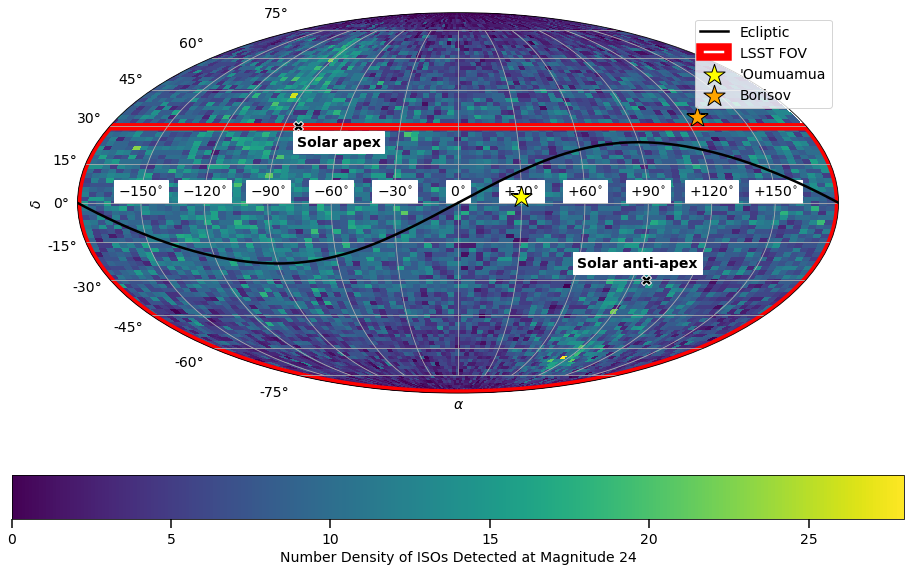

In [28]:
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

origin_pos = []
det_pos = []
bright_pos = []
lsst_pos = []
lsst_mag = []
for i in range(NDETECT):
    det = orbits['mag'][i] <= 24.
    bright = orbits['mag'][i] <= 19.
    lsst = det*(orbits['pos_horiz'][i][:, 1] > np.radians(30.))*\
        (orbits['solar_pos_horiz'][i][:, 1] < np.radians(-18.))
    if True in det:
        j = np.where(orbits['mag'][i][det] == orbits['mag'][i][det][0])
        det_pos.append(orbits['pos_eq'][i][det][j])
        origin_pos.append(orbits['pos_eq'][i][0])
    if True in bright:
        j = np.where(orbits['mag'][i][bright] == orbits['mag'][i][bright][0])
        bright_pos.append(orbits['pos_eq'][i][bright][j])
    if True in lsst:
        j = np.where(orbits['mag'][i][lsst] == orbits['mag'][i][lsst][0])
        lsst_pos.append(orbits['pos_eq'][i][lsst][j])
        lsst_mag.append(orbits['mag'][i][lsst][j])
           
print(np.array(bright_pos).shape)
origin_pos = np.reshape(origin_pos, (NDETECT, 2))
det_pos = np.reshape(det_pos, (NDETECT, 2))
bright_pos = np.reshape(bright_pos, (528, 2))
lsst_pos = np.reshape(lsst_pos, (nobs, 2))
lsst_mag = np.reshape(lsst_mag, nobs)

'''
print(np.array(det_pos).shape)
det_pos = np.reshape(det_pos, (9623, 2))
print(np.array(lsst_pos).shape)
lsst_pos = np.reshape(lsst_pos, (1857, 2))
lsst_mag = np.reshape(lsst_mag, 1857)
'''
    
fig = plt.figure(figsize=(16, 10))
ax = plt.subplot(111, projection='mollweide')

H, xedges, yedges = np.histogram2d(det_pos[:, 0], det_pos[:, 1], bins=100)
im = ax.pcolormesh(xedges[:-1], yedges[:-1], H.T, cmap='viridis', shading='auto', zorder=-1)

plt.colorbar(im, orientation='horizontal', label='Number Density of ISOs Detected at Magnitude 24')

ax = plt.gca()
ax.add_patch(Rectangle((np.min(lsst_pos[:, 0]), np.min(lsst_pos[:, 1])), \
    np.max(lsst_pos[:, 0])-np.min(lsst_pos[:, 0]), \
    np.max(lsst_pos[:, 1])-np.min(lsst_pos[:, 1]), \
    fill=None, lw=7.5, edgecolor='red', label='LSST FOV', zorder=-0.5))

'''
ax.scatter(np.radians(192.85-360.), np.radians(27.13), s=100., c='black', marker='X', edgecolors='white', zorder=1)
ax.text(np.radians(-163), np.radians(25), 'NGP', color='black', weight='bold')
ax.scatter(np.radians(12.85), np.radians(-27.13), s=100., c='black', marker='X', edgecolors='white', zorder=1)
ax.text(np.radians(10), np.radians(-25), 'SGP', color='black', weight='bold')
'''

ax.scatter(np.radians(277.-360.), np.radians(30.), s=100., c='black', marker='X', edgecolors='white', zorder=1)
ax.text(np.radians(-80.), np.radians(22), 'Solar apex', color='black', weight='bold', backgroundcolor='white')
ax.scatter(np.radians(97.), np.radians(-30.), s=100., c='black', marker='X', edgecolors='white', zorder=1)
ax.text(np.radians(60.), np.radians(-25), 'Solar anti-apex', color='black', weight='bold', backgroundcolor='white')

ecliptic_long = np.linspace(0, 2*pi, 1000)
ecliptic_lat = np.zeros(1000)
ecliptic_dec = np.arcsin(np.sin(ecliptic_lat)*np.cos(np.radians(23.5)) + \
                         np.cos(ecliptic_lat)*np.sin(np.radians(23.5))*np.sin(ecliptic_long))
ecliptic_ra = np.arccos(np.cos(ecliptic_long)*np.cos(ecliptic_lat)/np.cos(ecliptic_dec))
ax.plot(ecliptic_ra[ecliptic_dec>0], ecliptic_dec[ecliptic_dec>0], label='Ecliptic', c='black', lw=2.5)
ax.plot(ecliptic_ra[ecliptic_dec<0]-pi, ecliptic_dec[ecliptic_dec<0], c='black', lw=2.5)

'''
pole_ra = np.radians(192.859508)
pole_dec = np.radians(27.128336)
posangle = np.radians(122.932-90.)
galactic_long = np.copy(ecliptic_long)
galactic_lat = np.copy(ecliptic_lat)
galactic_ra = np.arctan2(np.cos(galactic_lat)*np.cos(galactic_long-posangle), \
            np.sin(galactic_lat)*np.cos(pole_dec) - np.cos(galactic_lat)*np.sin(pole_dec)*np.sin(galactic_long-posangle)) + pole_ra
galactic_dec = np.arcsin(np.cos(galactic_lat)*np.cos(pole_dec)*np.sin(galactic_long-posangle) + np.sin(galactic_lat)*np.sin(pole_dec))
order = np.argsort(galactic_ra)
galactic_ra = galactic_ra[order]
galactic_dec = galactic_dec[order]
ax.plot(galactic_ra[galactic_ra<pi], galactic_dec[galactic_ra<pi], label='Galactic equator', c='black', lw=2.5, linestyle='dashed')
ax.plot(galactic_ra[galactic_ra>pi]-2*pi, galactic_dec[galactic_ra>pi], c='black', lw=2.5, linestyle='dashed')
'''

ax.scatter(np.radians(29.9893416667), np.radians(2.10119444444), c='yellow', edgecolor='k', label="'Oumuamua", \
           marker='*', s=500., zorder=2)
ax.scatter(np.radians(126.657583333), np.radians(33.6646388889), c='orange', edgecolor='k', \
           marker='*', s=500., label="Borisov")  # from MPECs

plt.xlabel(r'$\alpha$')
plt.xticks([-5*pi/6, -2*pi/3, -pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2, 2*pi/3, 5*pi/6], [ \
        r'$-150^{\circ}$', r'$-120^{\circ}$', r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', r'$0^{\circ}$', \
        r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$', r'$+120^{\circ}$', r'$+150^{\circ}$'], \
        backgroundcolor='white')

plt.ylabel(r'$\delta$')
plt.grid(True)
plt.legend(loc='upper right')

plt.savefig('figures/detectable_pos.pdf', bbox_inches='tight', dpi=250)
plt.show()

## Moment where ISOs become detectable; minimum apparent magnitude less than 22

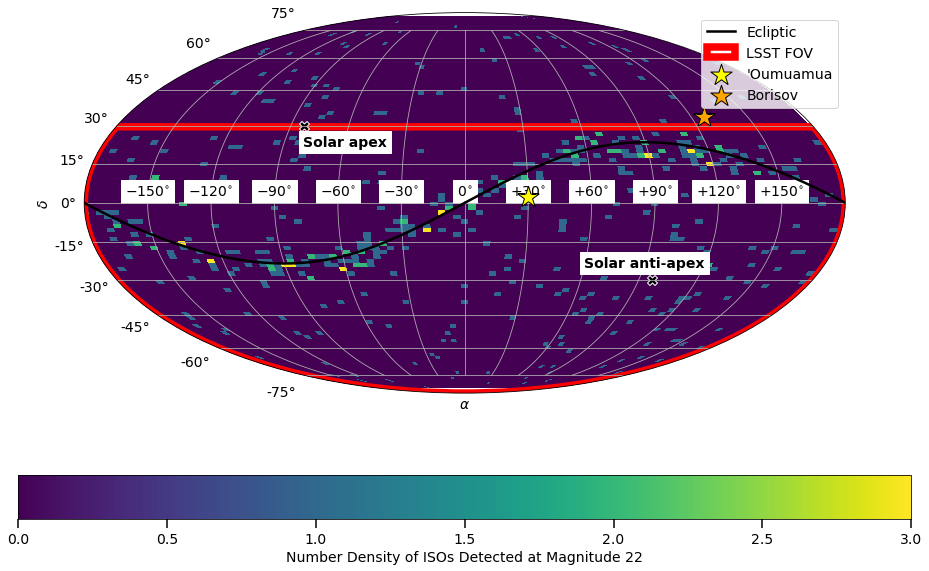

In [29]:
fig = plt.figure(figsize=(16, 10))
ax = plt.subplot(111, projection='mollweide')

H, xedges, yedges = np.histogram2d(bright_pos[:, 0], bright_pos[:, 1], bins=100)
im = ax.pcolormesh(xedges[:-1], yedges[:-1], H.T, cmap='viridis', shading='auto', zorder=-1)

plt.colorbar(im, orientation='horizontal', label='Number Density of ISOs Detected at Magnitude 22')

ax = plt.gca()
ax.add_patch(Rectangle((np.min(lsst_pos[:, 0]), np.min(lsst_pos[:, 1])), \
    np.max(lsst_pos[:, 0])-np.min(lsst_pos[:, 0]), \
    np.max(lsst_pos[:, 1])-np.min(lsst_pos[:, 1]), \
    fill=None, lw=7.5, edgecolor='red', label='LSST FOV', zorder=-0.5))

'''
ax.scatter(np.radians(192.85-360.), np.radians(27.13), s=100., c='black', marker='X', edgecolors='white', zorder=1)
ax.text(np.radians(-163), np.radians(25), 'NGP', color='black', weight='bold')
ax.scatter(np.radians(12.85), np.radians(-27.13), s=100., c='black', marker='X', edgecolors='white', zorder=1)
ax.text(np.radians(10), np.radians(-25), 'SGP', color='black', weight='bold')
'''

ax.scatter(np.radians(277.-360.), np.radians(30.), s=100., c='black', marker='X', edgecolors='white', zorder=1)
ax.text(np.radians(-80.), np.radians(22), 'Solar apex', color='black', weight='bold', backgroundcolor='white')
ax.scatter(np.radians(97.), np.radians(-30.), s=100., c='black', marker='X', edgecolors='white', zorder=1)
ax.text(np.radians(60.), np.radians(-25), 'Solar anti-apex', color='black', weight='bold', backgroundcolor='white')

ecliptic_long = np.linspace(0, 2*pi, 1000)
ecliptic_lat = np.zeros(1000)
ecliptic_dec = np.arcsin(np.sin(ecliptic_lat)*np.cos(np.radians(23.5)) + \
                         np.cos(ecliptic_lat)*np.sin(np.radians(23.5))*np.sin(ecliptic_long))
ecliptic_ra = np.arccos(np.cos(ecliptic_long)*np.cos(ecliptic_lat)/np.cos(ecliptic_dec))
ax.plot(ecliptic_ra[ecliptic_dec>0], ecliptic_dec[ecliptic_dec>0], label='Ecliptic', c='black', lw=2.5)
ax.plot(ecliptic_ra[ecliptic_dec<0]-pi, ecliptic_dec[ecliptic_dec<0], c='black', lw=2.5)

'''
pole_ra = np.radians(192.859508)
pole_dec = np.radians(27.128336)
posangle = np.radians(122.932-90.)
galactic_long = np.copy(ecliptic_long)
galactic_lat = np.copy(ecliptic_lat)
galactic_ra = np.arctan2(np.cos(galactic_lat)*np.cos(galactic_long-posangle), \
            np.sin(galactic_lat)*np.cos(pole_dec) - np.cos(galactic_lat)*np.sin(pole_dec)*np.sin(galactic_long-posangle)) + pole_ra
galactic_dec = np.arcsin(np.cos(galactic_lat)*np.cos(pole_dec)*np.sin(galactic_long-posangle) + np.sin(galactic_lat)*np.sin(pole_dec))
order = np.argsort(galactic_ra)
galactic_ra = galactic_ra[order]
galactic_dec = galactic_dec[order]
ax.plot(galactic_ra[galactic_ra<pi], galactic_dec[galactic_ra<pi], label='Galactic equator', c='black', lw=2.5, linestyle='dashed')
ax.plot(galactic_ra[galactic_ra>pi]-2*pi, galactic_dec[galactic_ra>pi], c='black', lw=2.5, linestyle='dashed')
'''

ax.scatter(np.radians(29.9893416667), np.radians(2.10119444444), c='yellow', edgecolor='k', label="'Oumuamua", \
           marker='*', s=500., zorder=2)
ax.scatter(np.radians(126.657583333), np.radians(33.6646388889), c='orange', edgecolor='k', \
           marker='*', s=500., label="Borisov")  # from MPECs

plt.xlabel(r'$\alpha$')
plt.xticks([-5*pi/6, -2*pi/3, -pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2, 2*pi/3, 5*pi/6], [ \
        r'$-150^{\circ}$', r'$-120^{\circ}$', r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', r'$0^{\circ}$', \
        r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$', r'$+120^{\circ}$', r'$+150^{\circ}$'], \
        backgroundcolor='white')

plt.ylabel(r'$\delta$')
plt.grid(True)
plt.legend(loc='upper right')

plt.savefig('figures/bright_pos.pdf', bbox_inches='tight', dpi=250)
plt.show()

## Moment where ISOs enter solar system; minimum apparent magnitude less than 24

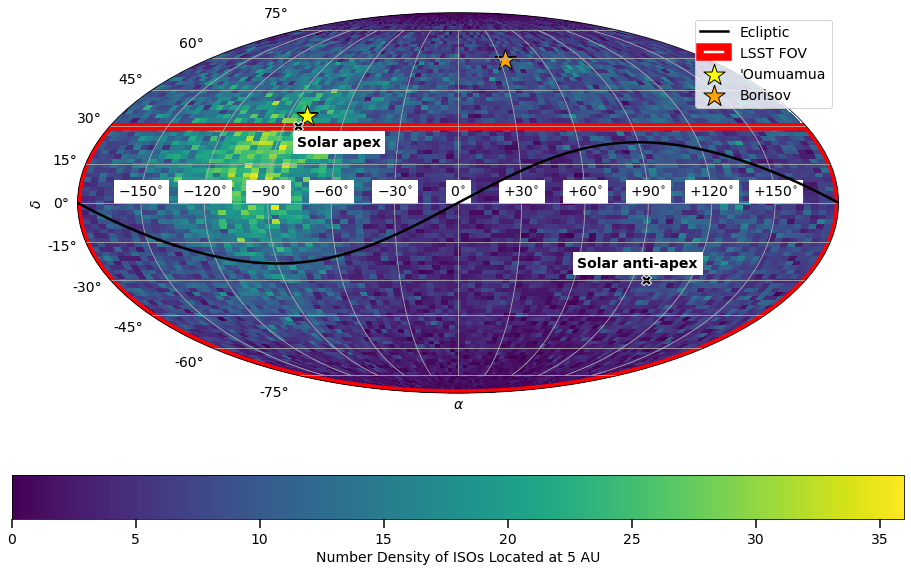

In [30]:
OUMUAMUA_COORDS = [np.radians(279.804-360.), np.radians(33.997)]
BORISOV_COORDS = [np.radians(33.75), np.radians(59.04)]

fig = plt.figure(figsize=(16, 10))
ax = plt.subplot(111, projection='mollweide')

ax.scatter(OUMUAMUA_COORDS[0], OUMUAMUA_COORDS[1], c='yellow', edgecolor='k', s=500., marker='*', label="'Oumuamua")
ax.scatter(BORISOV_COORDS[0], BORISOV_COORDS[1], c='orange', edgecolor='k', s=500., marker='*', label="Borisov")

H, xedges, yedges = np.histogram2d(origin_pos[:, 0], origin_pos[:, 1], bins=100)
im = ax.pcolormesh(xedges[:-1], yedges[:-1], H.T, cmap='viridis', shading='auto', zorder=-1)

plt.colorbar(im, orientation='horizontal', label='Number Density of ISOs Located at 5 AU')

ax = plt.gca()
ax.add_patch(Rectangle((np.min(lsst_pos[:, 0]), np.min(lsst_pos[:, 1])), \
    np.max(lsst_pos[:, 0])-np.min(lsst_pos[:, 0]), \
    np.max(lsst_pos[:, 1])-np.min(lsst_pos[:, 1]), \
    fill=None, lw=7.5, edgecolor='red', label='LSST FOV', zorder=-0.5))

ax.scatter(np.radians(277.-360.), np.radians(30.), s=100., c='black', marker='X', edgecolors='white', zorder=1)
ax.text(np.radians(-80.), np.radians(22), 'Solar apex', color='black', weight='bold', backgroundcolor='white')
ax.scatter(np.radians(97.), np.radians(-30.), s=100., c='black', marker='X', edgecolors='white', zorder=1)
ax.text(np.radians(60.), np.radians(-25), 'Solar anti-apex', color='black', weight='bold', backgroundcolor='white')

ecliptic_long = np.linspace(0, 2*pi, 1000)
ecliptic_lat = np.zeros(1000)
ecliptic_dec = np.arcsin(np.sin(ecliptic_lat)*np.cos(np.radians(23.5)) + \
                         np.cos(ecliptic_lat)*np.sin(np.radians(23.5))*np.sin(ecliptic_long))
ecliptic_ra = np.arccos(np.cos(ecliptic_long)*np.cos(ecliptic_lat)/np.cos(ecliptic_dec))
ax.plot(ecliptic_ra[ecliptic_dec>0], ecliptic_dec[ecliptic_dec>0], label='Ecliptic', c='black', lw=2.5)
ax.plot(ecliptic_ra[ecliptic_dec<0]-pi, ecliptic_dec[ecliptic_dec<0], c='black', lw=2.5)

plt.xlabel(r'$\alpha$')
plt.xticks([-5*pi/6, -2*pi/3, -pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2, 2*pi/3, 5*pi/6], [ \
        r'$-150^{\circ}$', r'$-120^{\circ}$', r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', r'$0^{\circ}$', \
        r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$', r'$+120^{\circ}$', r'$+150^{\circ}$'], \
        backgroundcolor='white')

plt.ylabel(r'$\delta$')
plt.grid(True)
plt.legend(loc='upper right')

plt.savefig('figures/origin_pos.pdf', bbox_inches='tight', dpi=250)
plt.show()

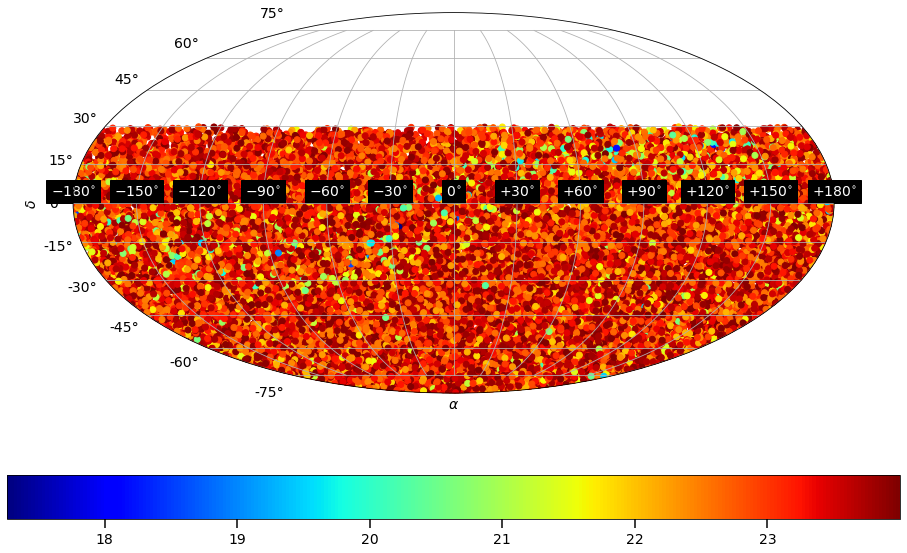

In [31]:
plt.figure(figsize=(16,10))
ax = plt.subplot(111, projection='mollweide')

sc = ax.scatter(lsst_pos[:, 0], lsst_pos[:, 1], c=lsst_mag, cmap='jet')
plt.colorbar(sc, orientation='horizontal')

plt.xlabel(r'$\alpha$')
plt.xticks([-pi, -5*pi/6, -2*pi/3, -pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2, 2*pi/3, 5*pi/6, pi], [r'$-180^{\circ}$', \
        r'$-150^{\circ}$', r'$-120^{\circ}$', r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', r'$0^{\circ}$', \
        r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$', r'$+120^{\circ}$', r'$+150^{\circ}$', r'$+180^{\circ}$'], \
          backgroundcolor='black', color='white')

plt.ylabel(r'$\delta$')
plt.grid(True)

plt.savefig('figures/lsst_scatter.pdf', bbox_inches='tight', dpi=250)
plt.show()

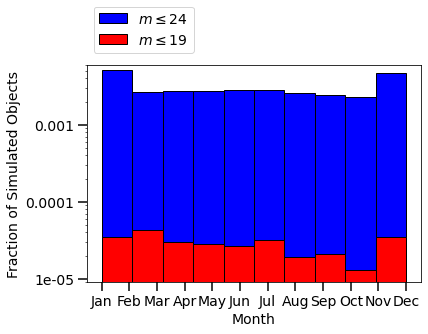

In [32]:
det_month = np.zeros(NDETECT)
for i in range(NDETECT):
    det_month[i] = orbits['datetime'][i][orbits['mag'][i] == \
                    orbits['mag'][i][det_ind]][0][1]

plt.hist(det_month[(min_mag <= 24.)*(detectable)], color='blue', edgecolor='k', \
        label=r'$m\leq 24$')
plt.hist(det_month[(min_mag <= 19.)*(detectable)], color='red', edgecolor='k', \
        label=r'$m\leq 19$')

plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', \
                             'May', 'Jun', 'Jul', 'Aug', 'Sep', \
                              'Oct', 'Nov', 'Dec'])
plt.xlabel('Month')
plt.ylabel('Fraction of Simulated Objects')
plt.yscale('log')
plt.yticks([10**1, 10**2, 10**3], np.array([10, 100, 1000])/NSAMPLES)
plt.ylim(9*10**0, 6*10**3)

plt.legend(bbox_to_anchor=(0., 1.3), loc='upper left')
plt.savefig('figures/month_detect.pdf', bbox_inches='tight', dpi=250)
plt.show()

In [33]:
print(r'$\Delta v\leq 2$ km/s: %.3f %%' \
      %(len(dv[(dv <= 2.)*detectable])/NSAMPLES*100))
print(r'$\Delta v\leq 15$ km/s: %.3f %%' \
      %(len(dv[(dv <= 15.)*detectable])/NSAMPLES*100))
print(r'$\Delta v\leq 30$ km/s: %.3f %%' \
      %(len(dv[(dv <= 30.)*detectable])/NSAMPLES*100))

$\Delta v\leq 2$ km/s: 0.003 %
$\Delta v\leq 15$ km/s: 0.471 %
$\Delta v\leq 30$ km/s: 1.169 %
